In [1]:
from bda_prophet import bda_prophet
from fbprophet import Prophet
import pandas as pd
from datetime import datetime
from bda_bokeh import bda_bokeh
from sklearn.metrics import mean_absolute_error





In [2]:
df = bda_bokeh.import_data()
df = bda_bokeh.preprocessing(df)

#from fbprophet.plot import plot_plotly
#import plotly.offline as py

country_codes = bda_prophet.extract_country_codes(df)
df = bda_prophet.get_net_export(df, country_codes, ["EX","IM"])
df.head()

Import File: DE_Physikalischer Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer Stromfluss_201706020000_201906022359_1.csv 


,Date,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,PL
0,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,1279.0
1,2015-06-01 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,1142.0
2,2015-06-01 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,1134.0
3,2015-06-01 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,1090.0
4,2015-06-01 04:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,1083.0


In [33]:
def get_outliers(df, factor):
    '''
    Returns the index of outliers concerning NX in a list.
    :param df:
    :param factor: factor of the std. after which entries are considered outliers.
    :return:
    '''
    idxs = df[df['NX'] > df['NX'].mean() + factor * df['NX'].std()]
    return idxs
df.drop(get_outliers(df,3).index, inplace=True)

In [34]:
def train_prophet_model(df, country_code, train_until_including="2019-4-30"):
    df = df[df['Date']<= train_until_including]
    print("start training: " + country_code)
    df_temp = df[['Date', country_code]]
    df_temp = bda_prophet.rename_columns_for_prophet(df_temp)
    m = Prophet()
    m.fit(df_temp) 
    return m
 
       

In [35]:
country_code="AUT"
m = train_prophet_model(df, country_code)

start training: AUT


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [36]:
def make_prediction_df(df, country_code, model, start_date=datetime(2019,5,1), end_date=datetime(2019,5,31,23,0,0)):
    df_prediction = df[['Date', country_code]]
    df_prediction = df_prediction.rename(columns={'Date': 'ds', country_code: 'y'})

    future = pd.DataFrame({"ds": pd.date_range(start=start_date, end=end_date, freq="1H")})
    forecast = m.predict(future) 
    
    df_prediction = df_prediction.merge(forecast[['ds','yhat']])
    return df_prediction

In [37]:
pred_df = make_prediction_df(df, country_code, m)


In [38]:
def evaluate(y, yhat, error_function):
    return error_function(y, yhat)


In [39]:
print(evaluate(pred_df['y'], pred_df['yhat'], mean_absolute_error))

532.4042574327184


In [40]:
def save_plot(pred_df, country_code, save_path="./prophet_plots/"):
    figure = pred_df[['y','yhat']].plot().get_figure()
    figure.savefig(save_path + country_code + ".pdf")
    

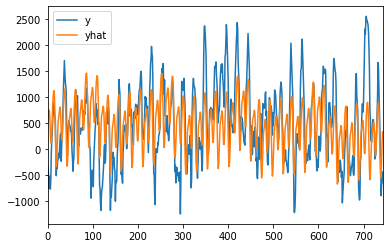

In [41]:
save_plot(pred_df, country_code)